## Set up to pull data from Stack Overflow

In [3]:
import stackexchange, os

api_key = os.environ['SO_PASSWORD']

so = stackexchange.Site(stackexchange.StackOverflow,api_key)
so.be_inclusive()
so.impose_throttling = True
so.throttle_stop = False

from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize

url = 'http://stackoverflow.com/questions/3501382/checking-whether-a-variable-is-an-integer-or-not'
q_id = [3501382]
question = so.question(q_id)

p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer('\w+')

## Build Model

In [73]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.layers import Dense, Input, GRU, Embedding
from keras.models import Model
import six.moves.cPickle as cPickle

MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 300
word_index_length = 374000

embedding_layer = Embedding(word_index_length + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = GRU(128, dropout_W=0.2, dropout_U=0.2)(embedded_sequences)
preds = Dense(2, activation='softmax')(x)

mymodel = Model(sequence_input, preds)
mymodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
mymodel.load_weights('../Data_and_Models/stackex_gru.h5')
print('Gimme that overflow!')
vectorizer = cPickle.load(open('../Data_and_Models/rnn_tokenizer.pkl', 'rb'), encoding='latin1')
lg = mymodel

Gimme that overflow!


## Modified StackExchange_Query.py

In [131]:
import numpy as np

def fetch_and_clean(text,model_prep=False):
    raw = BeautifulSoup(text, "lxml").get_text()
    raw = raw.lower()

    if model_prep == False:
        tokens = text_to_word_sequence(raw)
    elif model_prep == True:
        tokens = tokenizer.tokenize(raw)
        tokens = [word for word in tokens if not word.isdigit()]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = [p_stemmer.stem(i) for i in tokens]
    return tokens

def sentences_tokenization(text):
    raw = BeautifulSoup(text, "lxml").get_text()
    raw = raw.lower()
    sentences = sent_tokenize(raw)
    return sentences

def sentences_or_not(text, sentences=True):
    if sentences == False:
        output = fetch_and_clean(text)
    else:
        output = sentences_tokenization(text)
    return output

def get_answer_Info(question):
    answers_dict = {}
    text_source = question.json

    if 'comments' in text_source.keys():
        answer_id = -1
        for text in text_source['comments']:
            answer_id += 1
            temp_dict = {}
            temp_dict['tokens'] = sentences_or_not(text['body'])
            temp_dict['raw'] = text['body']
            temp_dict['score'] = text['score']
            answers_dict[answer_id] = temp_dict
    else:
        answer_id = -1

    if 'answers' in text_source.keys():
        for text in text_source['answers']:
            answer_id += 1
            temp_dict = {}
            temp_dict['tokens'] = sentences_or_not(text['body'])
            temp_dict['raw'] = [text['body']]
            temp_dict['score'] = text['score']

            if 'comments' in text.keys():
                for comments in text['comments']:
                    temp_dict['tokens'].extend(sentences_or_not(comments['body']))
                    temp_dict['raw'].extend(comments['body']) #was extend
                    temp_dict['score'] += comments['score']

            temp_dict['raw'] = ''.join(temp_dict['raw'])
            answers_dict[answer_id] = temp_dict

    return answers_dict
    
def find_helpful_sentences(answers_dict, help_threshold=0.0,print_on=False):
    new_answer_dict = answers_dict
    answers = []
    sent = []

    for keys in new_answer_dict:
        a_dict = new_answer_dict[keys]
        a_vect = a_dict['tokens']
        a_raw = a_dict['raw']
        just_tok = [fetch_and_clean(x,model_prep=False) for x in a_vect]

        #print(just_tok)
        just_tok = [vectorizer.texts_to_sequences(x) for x in just_tok]
        temp = []
        for items in just_tok: temp.append([x[0] for x in items if len(x)>0])
        just_tok = temp

        padded_seq = pad_sequences(just_tok,maxlen=MAX_SEQUENCE_LENGTH)
        seq = np.array(padded_seq)
        
        y_pred = lg.predict(seq)
        y_pred = y_pred[:,1] - y_pred[:,0]
        
        sent.append(a_vect)
        answers.append(y_pred)

    return (sent, answers)

In [132]:
answers_dict = get_answer_Info(question)
(sent, answers) = find_helpful_sentences(answers_dict)

## Build Model Pipeline

In [133]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class MyRNN(BaseEstimator, TransformerMixin):
    def __init__(self, lg):
        self.lg = lg

    def predict(self, a_vect):
        just_tok = [fetch_and_clean(x,model_prep=False) for x in a_vect]
        just_tok = [vectorizer.texts_to_sequences(x) for x in just_tok]
        temp = []
        for items in just_tok: temp.append([x[0] for x in items if len(x)>0])
        just_tok = temp

        padded_seq = pad_sequences(just_tok,maxlen=MAX_SEQUENCE_LENGTH)
        seq = np.array(padded_seq)
        
        return self.lg.predict(seq)

In [138]:
RNN = MyRNN(lg)

array([[ 0.84269243,  0.15730758],
       [ 0.78681147,  0.2131885 ]], dtype=float32)

In [141]:
sent[1][0]

'@hulk: you seem to be under the impression that type is the right way to do this.'

In [143]:
sent_out = [item for sublist in sent for item in sublist]

In [150]:
RNN.predict([sent_out[0]])

array([[ 0.76623845,  0.23376152]], dtype=float32)

## See what my model is learning! (using lime - https://github.com/marcotcr/lime)

In [160]:
class_names = ['unhelpful', 'helpful']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

RNN = MyRNN(lg)
word_dict = {}

for items in sent_out[135:]:
    exp = explainer.explain_instance(items, RNN.predict, num_features=6)
    print(items)
    print('Probability(helpful) =', RNN.predict([items])[0,1])
    word_list = exp.as_list()
    for words in word_list:
        if words[0] in word_dict.keys():
            word_dict[words[0]] = np.append(word_dict[words[0]],words[1])
        else:
            word_dict[words[0]] = words[1]

/home/dan-laptop/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


what if the code still works (incorrectly) with non-ints, though, and that's what i'm trying to prevent?
Probability(helpful) = 0.0291237
you dismiss @scottgriffiths counterexample which, if valid, disproves your "never", with 'that's the only counter example.
Probability(helpful) = 0.297613
that's why i said "never"'.
Probability(helpful) = 0.057842
seriously?
Probability(helpful) = 0.120377
do you realize you're baiting people and wasting their time?
Probability(helpful) = 0.276034
if you really need to check then it's better to use abstract base classes rather than concrete classes.
Probability(helpful) = 0.212959
for an integer that would mean:
>>> import numbers
>>> isinstance(3, numbers.integral)
true

this doesn't restrict the check to just int, or just int and long, but also allows other user-defined types that behave as integers to work.

Probability(helpful) = 0.474277
isinstance(fraction(5,1), numbers.integral) → false.
Probability(helpful) = 0.402151
is that right?
Probabil

/home/dan-laptop/anaconda3/envs/insight/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


i.e.
Probability(helpful) = 0.0651213
floats fail, integers, even fancy integer classes that do not implement the integral abstract class work by duck typing.
Probability(helpful) = 0.453544
operator.index is what is used for list indexing, etc.
Probability(helpful) = 0.354848
and in my opinion it should be used for much more/promoted.
Probability(helpful) = 0.0194111
in fact i would argue it is the only correct way to get integer values if you want to be certain that floating points, due to truncating problems, etc.
Probability(helpful) = 0.116086
are rejected and it works with all integral types (i.e.
Probability(helpful) = 0.0604989
numpy, etc.)
Probability(helpful) = 0.313445
even if they may not (yet) support the abstract class.
Probability(helpful) = 0.122394
this is what __index__ was introduced for!

Probability(helpful) = 0.260654
seems to be just the thing.
Probability(helpful) = 0.106007
odd thing though: it accepts true and false but doesn't map them to 1 and 0, it returns 

In [161]:
len(word_dict)

516

## Save Data

In [1]:
import pickle

name = 'lime_dict'

In [174]:
with open('../Data_and_Models/'+ name + '.pkl', 'wb') as f:
    pickle.dump(word_dict, f, pickle.HIGHEST_PROTOCOL)

In [2]:
with open('../Data_and_Models/' + name + '.pkl', 'rb') as f:
    word_dict = pickle.load(f)

## Visualize Data

In [3]:
import numpy as np
num_wanted = 20
imp_word_dict = {}

for i in range(num_wanted):
    max_key = max(word_dict.keys(), key=(lambda x: abs(np.mean(word_dict[x]))))
    imp_word_dict[max_key] = np.mean(word_dict[max_key])
    word_dict.pop(max_key, None)

In [4]:
imp_word_dict

{'again': -0.093089059733018828,
 'bool': 0.087759564874848595,
 'classes': 0.13413944682057938,
 'concrete': -0.093464568384320573,
 'consider': 0.098667942178613827,
 'glad': -0.11133475232810838,
 'i': -0.093848591709584331,
 'int32': 0.091093118269160805,
 'is_integer': 0.10907147336080465,
 'isinstance': 0.13722364641677015,
 'iterable': 0.089119085435905673,
 'link': -0.088746006112689804,
 'martineau': -0.088881735896748137,
 'num': -0.099353389230151398,
 'perfect': 0.09596927225912999,
 'pythonic': 0.11194637263746457,
 'scott': -0.097653000063070927,
 'still': -0.10429664762535992,
 'thanks': -0.089778173961556129,
 'this_variable': -0.10020771436170887}

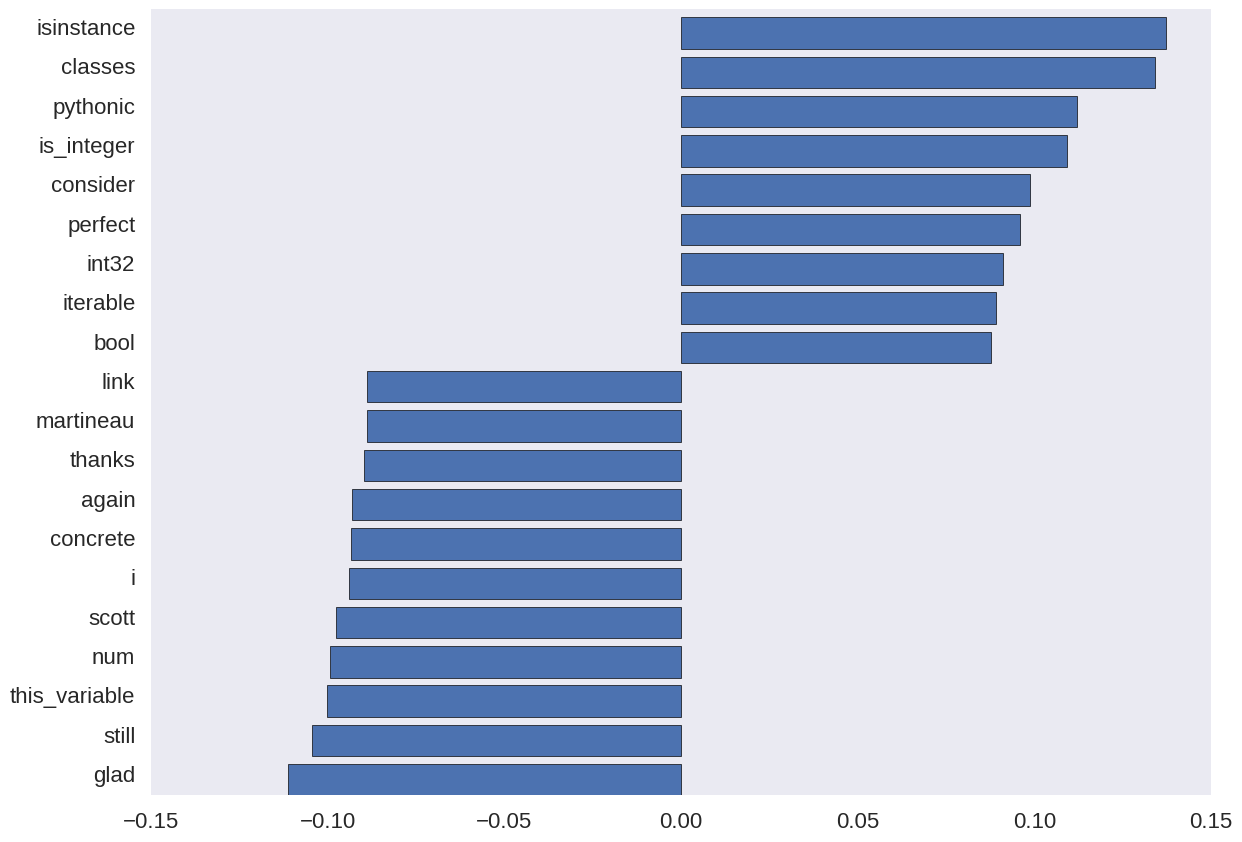

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("dark")

sorted_x = sorted(imp_word_dict, key=imp_word_dict.get)
sorted_y = [imp_word_dict[x] for x in sorted_x]

plt.barh(range(len(sorted_x)), sorted_y)
plt.yticks(np.arange(len(sorted_x))+0.5, sorted_x)

plt.tight_layout()
plt.show()

In [117]:
items

['@hulk: you seem to be under the impression that type is the right way to do this.',
 'it is (almost certainly) not.']

In [114]:
word_dict

{'canonical': 0.033773051465441559,
 'check': -0.071724063087750436,
 'duplicate': 0.039175234219797961,
 'possible': -0.024375775445865035,
 'python': 0.023019418089235359,
 's': 0.026437705602720015,
 'seem': 0.023015186501761417,
 'that': -0.0129267123790195,
 'this': -0.036796228488811485,
 'to': -0.01281247016068549,
 'way': 0.01404254601200421,
 'you': 0.056372161126580327}

## checking out what the data lime wants

In [55]:
#http://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']
newsgroups_test.data[83]

'From: johnchad@triton.unm.edu (jchadwic)\nSubject: Another request for Darwin Fish\nOrganization: University of New Mexico, Albuquerque\nLines: 11\nNNTP-Posting-Host: triton.unm.edu\n\nHello Gang,\n\nThere have been some notes recently asking where to obtain the DARWIN fish.\nThis is the same question I have and I have not seen an answer on the\nnet. If anyone has a contact please post on the net or email me.\n\nThanks,\n\njohn chadwick\njohnchad@triton.unm.edu\nor\n'

In [71]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

print(c.predict_proba([newsgroups_test.data[0]]))

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])


[[ 0.29  0.71]]


/home/dan-laptop/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 83
Probability(christian) = 0.446
True class: unhelpful
